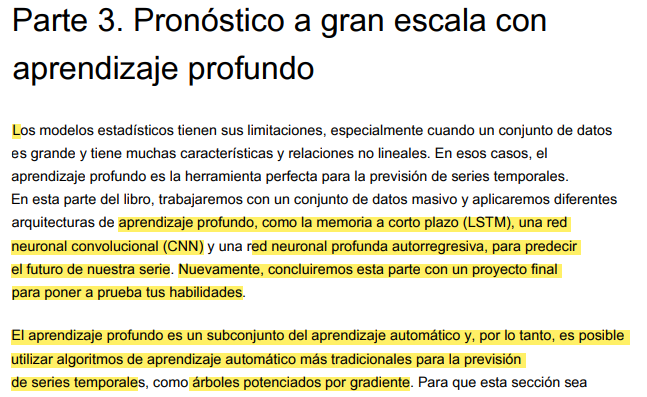

# Introducción al aprendizaje profundo para pronóstico de series temporales

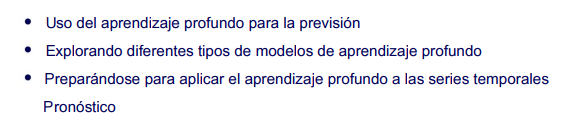

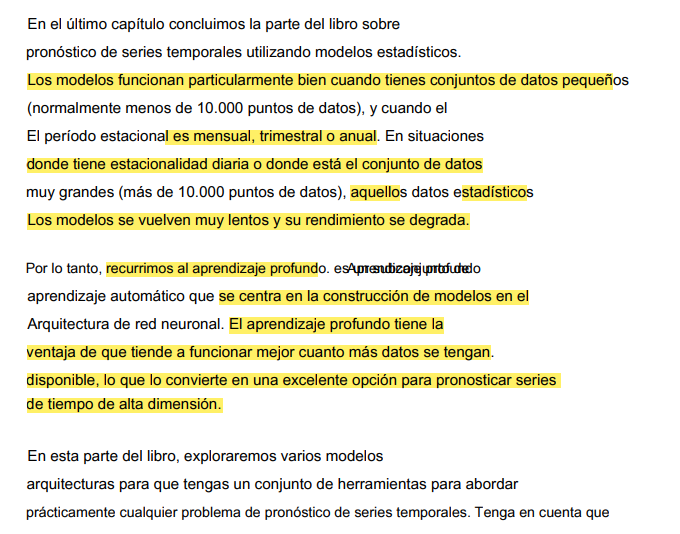

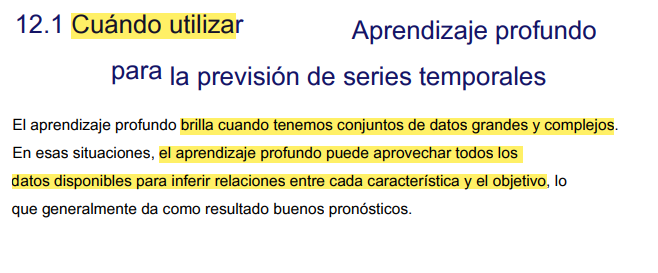

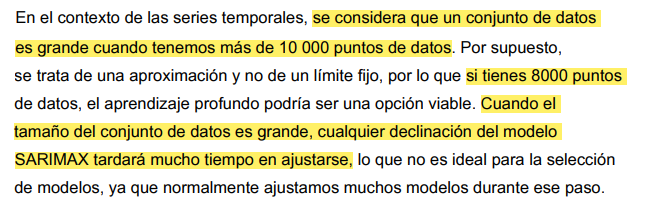

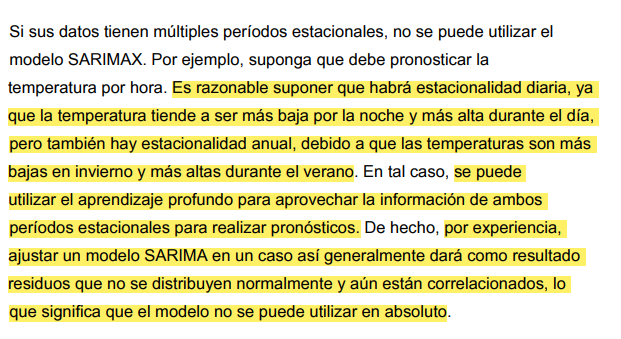

----

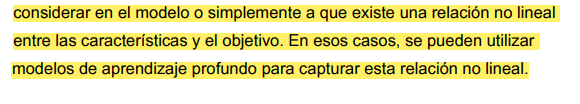

# TIPOS DIFERENTES DE MODELOS DE APRENDIZAJE PROFUNDO PARA SERIES TEMPORALES

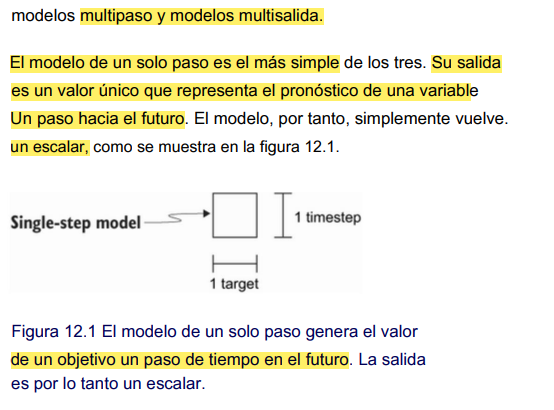

## 1) Modelo de un SOLO paso:

El modelo de un solo paso genera un único valor que representa la predicción para el siguiente 
paso de tiempo. La entrada puede tener cualquier longitud, pero la salida sigue siendo una 
única predicción para el siguiente paso de tiempo.

## 2)  MODELOS DE VARIOS PASOS:

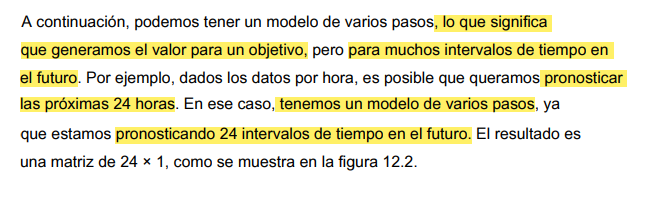

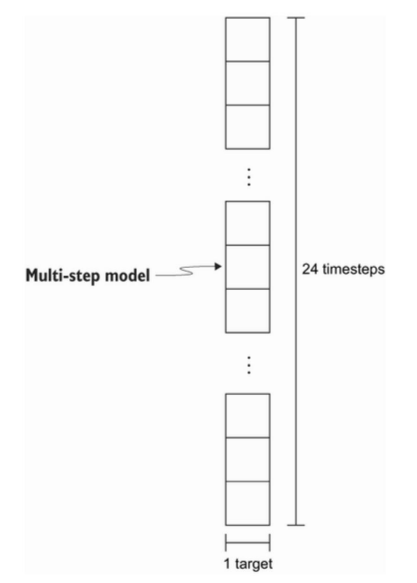

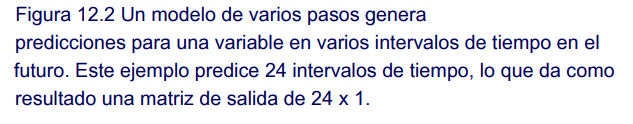

En un modelo de varios pasos, el resultado del modelo es una secuencia de valores 
que representan predicciones para muchos pasos de tiempo en el futuro. Por ejemplo, si
El modelo predice las próximas 6 horas, 24 horas o 12 meses, es un modelo de 
varios pasos.

## 3) MODELOS DE MULTIPLES SALIDAS: 

Un modelo de múltiples salidas genera predicciones para más de un objetivo. Por ejemplo, 
si pronosticamos la temperatura y la velocidad del viento, es un modelo de múltiples salidas.

Cada uno de estos modelos que manejan secuencialidad como (RNN, CNN, LSTM, etc) puede tener diferentes arquitecturas.

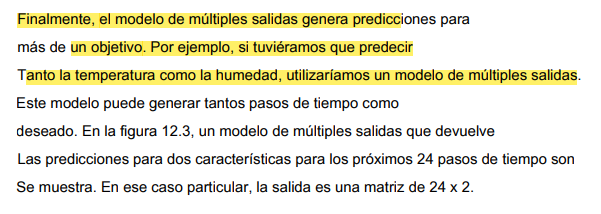

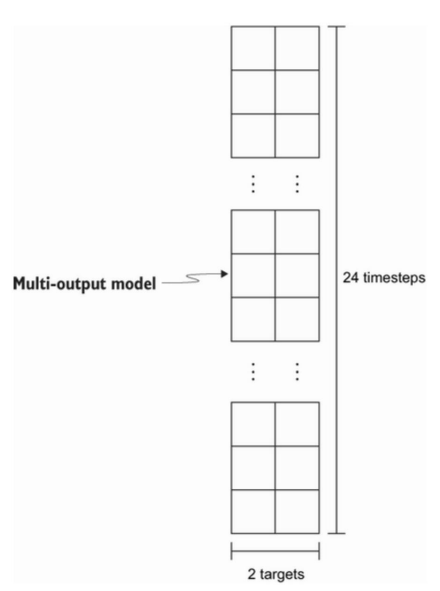

Figura 12.3 Un modelo de múltiples salidas realiza predicciones 
para más de un objetivo para uno o más intervalos de tiempo en 
el futuro. Aquí, el modelo genera predicciones para dos 
objetivos para los próximos 24 intervalos de tiempo.




----


## utilizaremos el conjunto de datos  ...
de volumen de tráfico interestatal del metro disponible en el repositorio 
de aprendizaje automático de UCI.

Nuestro principal objetivo de previsión es predecir el volumen de tráfico por 
hora. En el caso de los modelos de múltiples salidas, también Pronosticar la temperatura por hora. En esta configuración inicial para los próximos 
capítulos, cargaremos los datos, realizaremos ingeniería de características y los 
dividiremos en conjuntos de entrenamiento, validación y prueba

utilizaremos TensorFlow 2.6.0, o más específicamente Keras

## VARIABLES

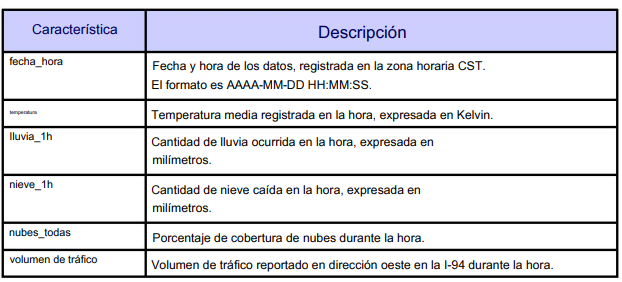

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.6.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
df = pd.read_csv('../data/metro_interstate_traffic_volume_preprocessed.csv')
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


In [6]:
df.tail()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
17546,2018-09-30 19:00:00,283.45,0.0,0,75,3543.0
17547,2018-09-30 20:00:00,282.76,0.0,0,90,2781.0
17548,2018-09-30 21:00:00,282.73,0.0,0,90,2159.0
17549,2018-09-30 22:00:00,282.09,0.0,0,90,1450.0
17550,2018-09-30 23:00:00,282.12,0.0,0,90,954.0


In [7]:
df.shape

(17551, 6)

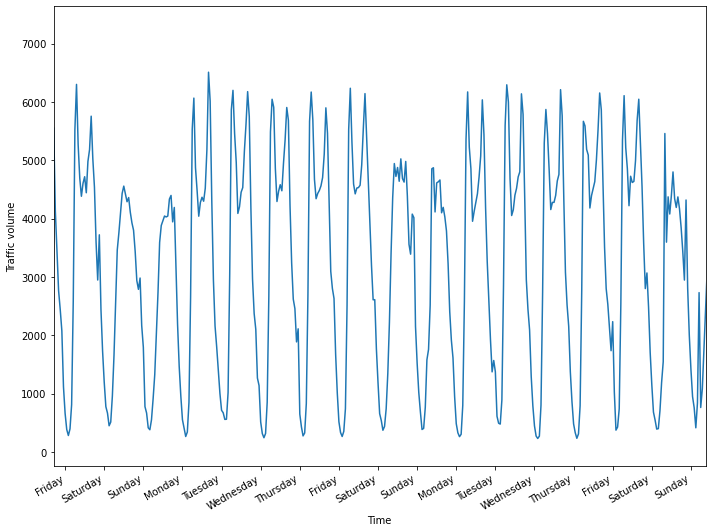

In [8]:
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

# Genera posiciones del eje X 
plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH12_F04_peixeiro.png', dpi=300)

# Interpretación

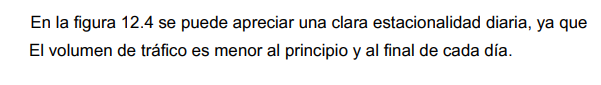

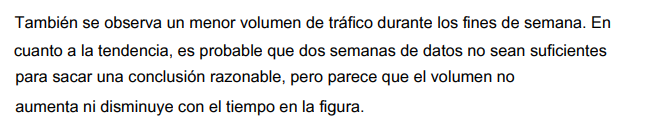

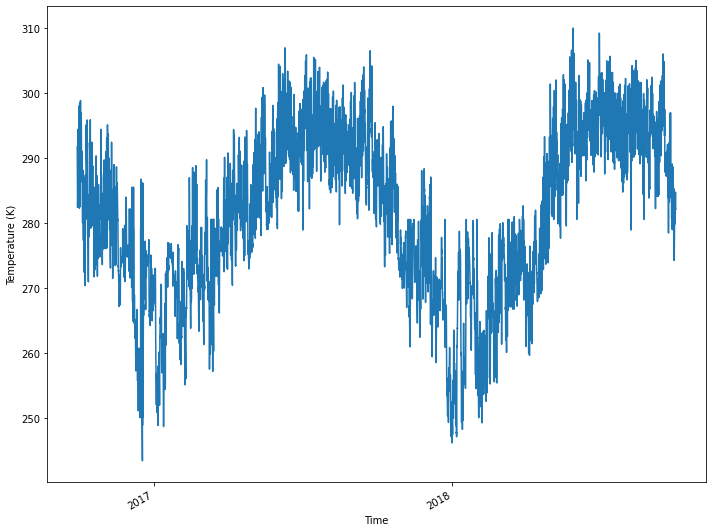

In [9]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH12_F05_peixeiro.png', dpi=300)

### Estacionalidad anual y diaria. 

La estacionalidad anual debería deberse 
a las estaciones del año, mientras que la estacionalidad diaria se deberá 
al hecho de que las temperaturas tienden a ser más bajas durante la 
noche y más altas durante el día.

Primero, visualicemos la temperatura horaria en todo el conjunto de 
datos para ver si podemos identificar alguna estacionalidad anual.

Se puede observar un patrón estacional anual 
en la temperatura horaria, ya que las temperaturas son más bajas a 
finales y principios de año (invierno en Minnesota) y más altas a 
mediados de año (verano). Por lo tanto, como se esperaba, la 
temperatura tiene estacionalidad anual.




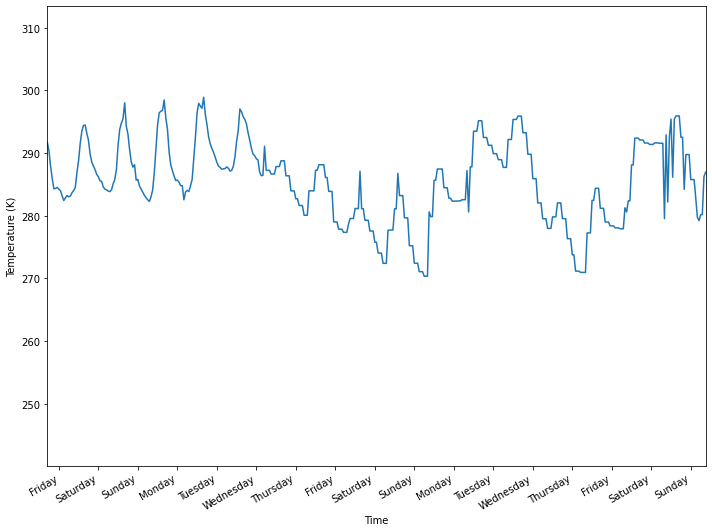

In [10]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH12_F06_peixeiro.png', dpi=300)

Se puede observar que la temperatura es más baja 
al principio y al final de cada día y alcanza su punto máximo hacia la 
mitad de cada día. Esto sugiere una estacionalidad diaria, tal como 
observamos para el volumen de tráfico en la figura

# Ingeniería de características y división de datos

Una vez finalizada la exploración de datos, pasaremos a la ingeniería de 
características y la división de datos.

 estudiaremos cada 
característica y crearemos otras nuevas que ayudarán a nuestros modelos a 
pronosticar el volumen de tráfico y la temperatura por hora.

Una excelente manera de estudiar las características de un conjunto de datos 
es utilizar el método describe de pandas. Este método devuelve la cantidad 
de registros para cada característica, lo que nos permite identificar rápidamente 
los valores faltantes, la media, la desviación estándar, los cuartiles y los 
valores máximos y mínimos de cada característica.

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


In [12]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

df.shape

(17551, 4)

.
Ahora llegamos al interesante problema de codificar el tiempo como una 
característica utilizable para nuestros modelos de aprendizaje profundo. En este 
momento, la característica date_time no es utilizable por nuestros modelos, ya 
que es una cadena de fecha y hora . Por lo tanto, la convertiremos en un 
valor numérico.

Una forma sencilla de hacerlo es expresar la fecha en segundos. Esto se logra 
mediante el uso del método de marca de tiempo de la biblioteca datetime

In [13]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

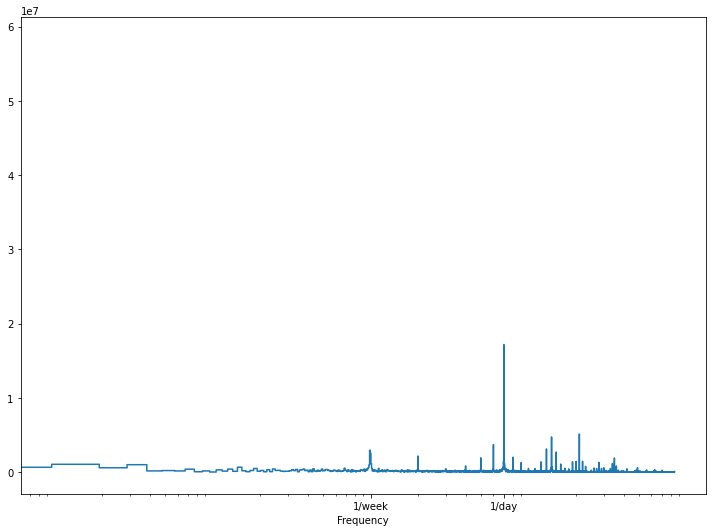

In [15]:
fft = tf.signal.rfft(df['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['traffic_volume'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [17]:
df = df.drop(['date_time'], axis=1)

df.head()

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0,5551.0,-7.071068e-01,0.707107
1,290.36,0,4132.0,-5.000000e-01,0.866025
2,287.86,0,3435.0,-2.588190e-01,0.965926
3,285.91,0,2765.0,-6.611980e-12,1.000000
4,284.31,0,2443.0,2.588190e-01,0.965926


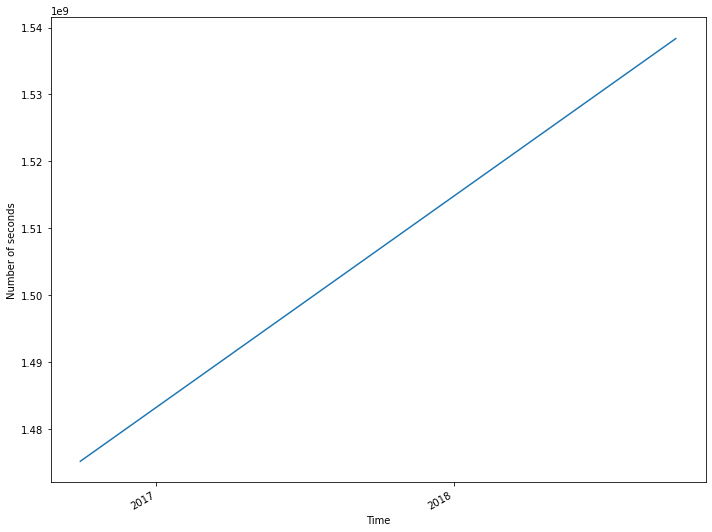

In [19]:
fig, ax = plt.subplots()

ax.plot(timestamp_s)
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH12_F07_peixeiro.png', dpi=300)

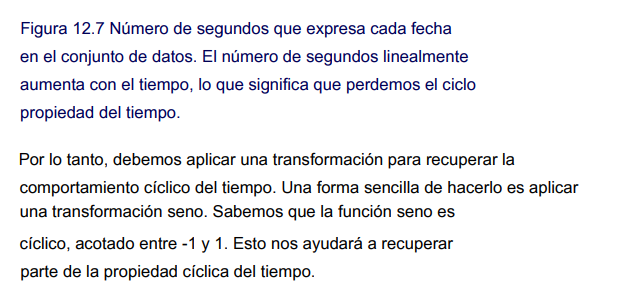

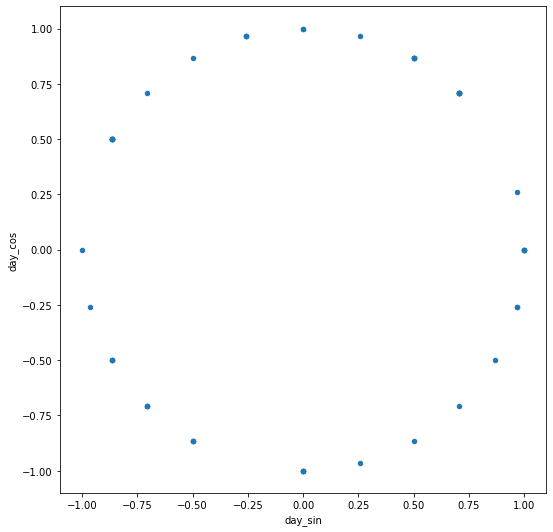

In [22]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

plt.savefig('figures/CH12_F08_peixeiro.png', dpi=300)

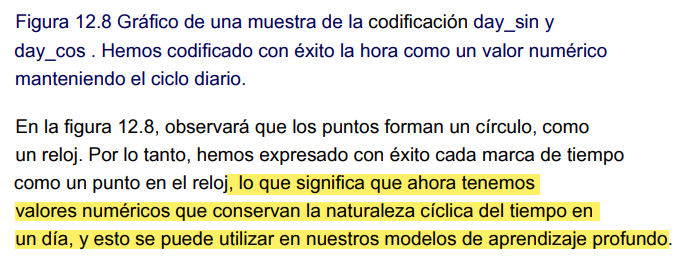

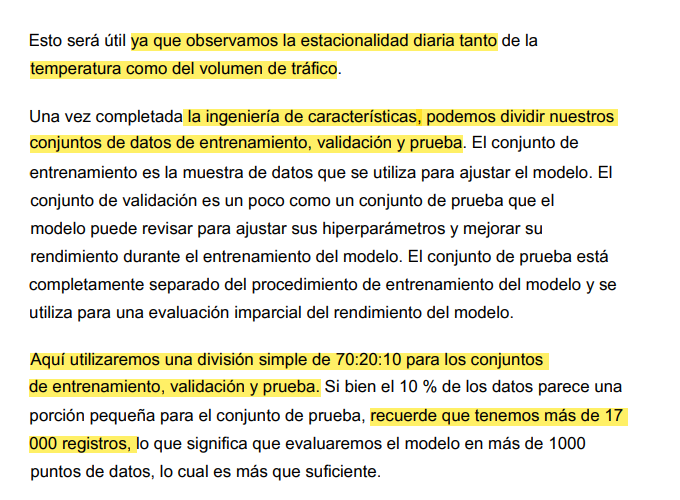

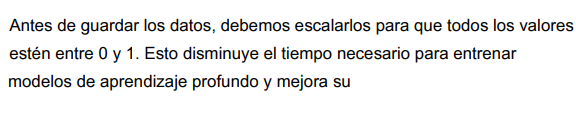



In [16]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((12285, 5), (3510, 5), (1756, 5))

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # Escalamos datos (entre 0 y 1)
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,12285.0,0.555681,0.196527,0.0,0.424800,0.557913,0.715072,1.0
clouds_all,12285.0,0.431034,0.393716,0.0,0.010000,0.400000,0.900000,1.0
traffic_volume,12285.0,0.445735,0.273635,0.0,0.165899,0.473141,0.671271,1.0
day_sin,12285.0,0.500032,0.353532,0.0,0.146447,0.500000,0.853553,1.0
day_cos,12285.0,0.499959,0.353604,0.0,0.146447,0.500000,0.853553,1.0


In [22]:
train_df.to_csv('../data/train.csv')
val_df.to_csv('../data/val.csv')
test_df.to_csv('../data/test.csv')

In [21]:
test_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
15795,0.767405,0.90,0.401563,0.500000,1.000000
15796,0.756876,0.90,0.348821,0.629410,0.982963
15797,0.754833,0.90,0.302637,0.750000,0.933013
15798,0.754833,0.90,0.187108,0.853553,0.853553
15799,0.756247,0.90,0.080926,0.933013,0.750000
...,...,...,...,...,...
17546,0.629577,0.75,0.478582,0.370590,0.982963
17547,0.618733,0.90,0.372262,0.500000,1.000000
17548,0.618262,0.90,0.285475,0.629410,0.982963
17549,0.608204,0.90,0.186549,0.750000,0.933013


# RESUMEN

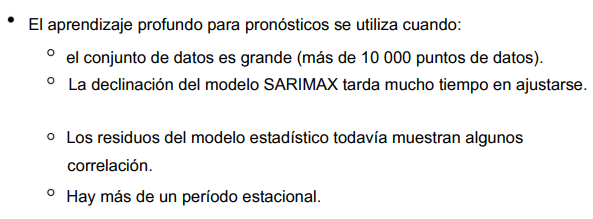

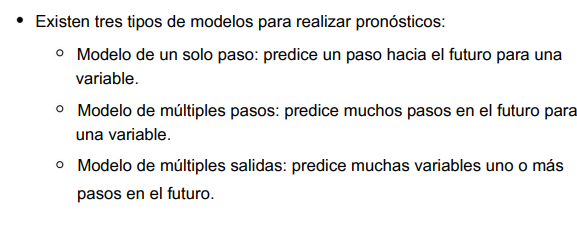